In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.pipeline import make_pipeline

# Reading Files and Data Preprocessing

In [8]:
df = pd.read_csv('../data/processedData/training_data.csv')
print(df.head())

             LOG_ID            PAT_ID               MRN  Cardiovascular   LOS  \
0  d754f06a7d973a26  837532f458d9c660  0b8de903ea63082a             0.0   1.0   
1  5a95970d5c8fc355  fd18a41f136ed278  0a8b72c1cec4ae47             0.0  10.0   
2  138d44a06cf4b57f  fd18a41f136ed278  0a8b72c1cec4ae47             0.0  10.0   
3  82372dc4703ea1b0  648781c95d863ec6  e0cb9244fedd1ac7             0.0   3.0   
4  4b6aabaf62e85c0a  d1d7b9ddc4962cdf  3918b79e03cefe27             0.0   3.0   

   ICU_ADMIN_FLAG      HEIGHT    WEIGHT  SEX  ASA_RATING_C  ...  \
0               0  187.960000   92.6991    1           2.0  ...   
1               1  168.251459  100.9530    1           3.0  ...   
2               1  168.251459  100.9530    1           3.0  ...   
3               1  160.020000   70.1064    0           2.0  ...   
4               1  168.251459   86.3922    1           2.0  ...   

   ecg_std_magnitude  Calcium  Erythrocyte distribution width  \
0          25.027281        0                

In [9]:
columns_to_scale = df.columns.difference(['LOG_ID', 'PAT_ID', 'MRN'])
scaler = MinMaxScaler(feature_range=(0, 1))
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
# print(df.head())
columns_list = df.columns
# print(columns_list)

In [10]:
columns_list = df.columns
# print(columns_list)

In [11]:
wave_path = '../data/processedData/waveform_features.csv'
# Read the CSV file
wave = pd.read_csv(wave_path)
print(wave.head())

             LOG_ID  systolic_peak  diastolic_peak  pulse_amplitude  \
0  00fbb475a02e94c3         252.12           32.00           220.11   
1  011e00acde3a3342       16279.61         1685.74         14593.87   
2  0124e746e00e3b4a        1520.99          189.51          1331.48   
3  01953a9111bff808        1304.10          171.75          1132.35   
4  01dc302bc8104d42        1958.25          290.57          1667.67   

   arc_peak_frequency  arc_spectral_energy  arc_bandwidth  qrs_freq_power  \
0                7.25         1.208174e+04          50.28          322.92   
1                8.29         1.854711e+08          47.16            0.64   
2                1.55         4.157098e+05          48.78         1452.14   
3               14.92         4.289385e+05          45.24            0.17   
4                0.55         1.068265e+06          45.21            0.36   

   vf_freq_power  vt_freq_power  qrs_peak_freq  ecg_std_magnitude  
0         434.57         869.92           

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
columns_to_normalize = wave.columns.drop('LOG_ID')
wave[columns_to_normalize] = scaler.fit_transform(wave[columns_to_normalize])
print(wave.head())

             LOG_ID  systolic_peak  diastolic_peak  pulse_amplitude  \
0  00fbb475a02e94c3       0.005692        0.006438         0.005534   
1  011e00acde3a3342       0.367523        0.339162         0.366926   
2  0124e746e00e3b4a       0.034337        0.038128         0.033476   
3  01953a9111bff808       0.029441        0.034555         0.028470   
4  01dc302bc8104d42       0.044209        0.058461         0.041929   

   arc_peak_frequency  arc_spectral_energy  arc_bandwidth  qrs_freq_power  \
0            0.307101             0.000009       0.520197        0.027332   
1            0.354138             0.134882       0.212808        0.000054   
2            0.049299             0.000302       0.372414        0.122909   
3            0.654003             0.000312       0.023645        0.000014   
4            0.004071             0.000777       0.020690        0.000030   

   vf_freq_power  vt_freq_power  qrs_peak_freq  ecg_std_magnitude  
0       0.041034       0.018431       0.00

In [15]:
missing_values = wave.isnull().sum()
print(missing_values)

LOG_ID                 0
systolic_peak          0
diastolic_peak         0
pulse_amplitude        0
arc_peak_frequency     0
arc_spectral_energy    0
arc_bandwidth          0
qrs_freq_power         0
vf_freq_power          0
vt_freq_power          0
qrs_peak_freq          0
ecg_std_magnitude      0
dtype: int64


In [31]:
# merged_df = pd.merge(df, wave, on='LOG_ID', how='inner')
# print(merged_df)
# print(merged_df.columns)
# print(merged_df.dtypes)

In [16]:
# Replace -1 with 0 in the 'Cardiovascular' column
df['Cardiovascular'] = df['Cardiovascular'].replace(-1, 0)

# Define feature set X and target variable y
X = df.drop(columns=['LOG_ID', 'PAT_ID', 'MRN', 'Cardiovascular'])
y = df['Cardiovascular']

# Add a constant (intercept) to the features for the logistic regression model
X = sm.add_constant(X)

# Fit the logistic regression model using Statsmodels
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Extract the coefficients and standard errors of the model
coefficients = result.params
std_errors = result.bse

# Calculate the z-values (coefficients divided by standard errors)
z_values = coefficients / std_errors

# Calculate p-values based on z-values
p_values = 2 * (1 - stats.norm.cdf(np.abs(z_values)))

# Uncomment this block if you want to print each variable's p-value
# for var, p_val in zip(X.columns, p_values):
#     print(f"Variable: {var}, p-value: {p_val}")

         Current function value: 0.329072
         Iterations: 35


c:\Users\user\anaconda3\anaconda\envs\comp90051_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Model Fitting

### Logistic Regression Model with All Features: Performance Evaluation and ROC Curve

              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       245
         1.0       0.80      0.63      0.71        76

    accuracy                           0.88       321
   macro avg       0.85      0.79      0.81       321
weighted avg       0.87      0.88      0.87       321

ROC AUC: 0.9023630504833512


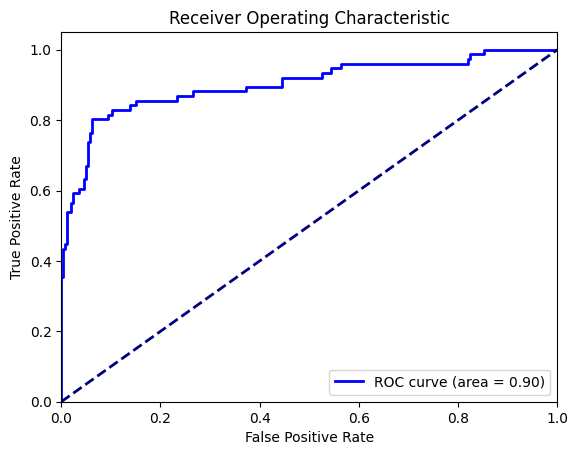

In [17]:
#All features

X = df.drop(columns=['LOG_ID', 'PAT_ID', 'MRN', 'Cardiovascular'])
y = df['Cardiovascular']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"ROC AUC: {roc_auc}")

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Logistic Regression with Selected Features (p-value < 0.1): Model Performance and ROC Curve

              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       245
         1.0       0.83      0.66      0.74        76

    accuracy                           0.89       321
   macro avg       0.87      0.81      0.83       321
weighted avg       0.88      0.89      0.88       321

ROC AUC: 0.8966433941997851


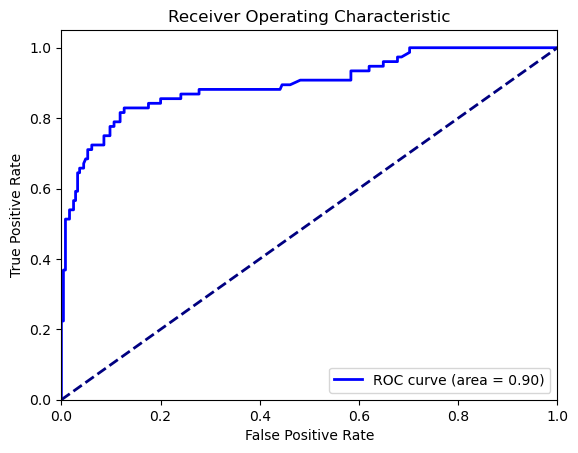

In [14]:
#p_value<0.1

# Select features with p-value < 0.1
significant_vars = ['LOS', 'ASA_RATING_C', 'ORDER_STATUS_IMPACT', 
                    'arc_peak_frequency', 'Erythrocyte distribution width', 
                    'Erythrocyte mean corpuscular hemoglobin', 
                    'Erythrocyte mean corpuscular hemoglobin concentration', 
                    'Erythrocytes', 'Hematocrit', 'cardiac_history']

X = df[significant_vars]
y = df['Cardiovascular'] 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict the target for the test set
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

# Print the classification report
print(classification_report(y_test, y_pred))

# Calculate the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"ROC AUC: {roc_auc}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [13]:
# significant_vars = [ 'LOS', 'ASA_RATING_C', 'ORDER_STATUS_IMPACT', 
#                     'Erythrocyte distribution width', 
#                     'Erythrocyte mean corpuscular hemoglobin', 
#                     'Erythrocyte mean corpuscular hemoglobin concentration', 
#                     'Erythrocytes', 'cardiac_history']

# X = df[significant_vars]  
# y = df['Cardiovascular']  

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# log_reg = LogisticRegression()
# log_reg.fit(X_train, y_train)

# y_pred = log_reg.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)

# print("Accuracy:", accuracy)
# print("AUC-ROC Score:", roc_auc)
# print("Confusion Matrix:\n", conf_matrix)

### Logistic Regression with Selected Features (p-value < 0.05): Model Performance and ROC Curve

              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       245
         1.0       0.83      0.66      0.74        76

    accuracy                           0.89       321
   macro avg       0.87      0.81      0.83       321
weighted avg       0.88      0.89      0.88       321

ROC AUC: 0.9028464017185821


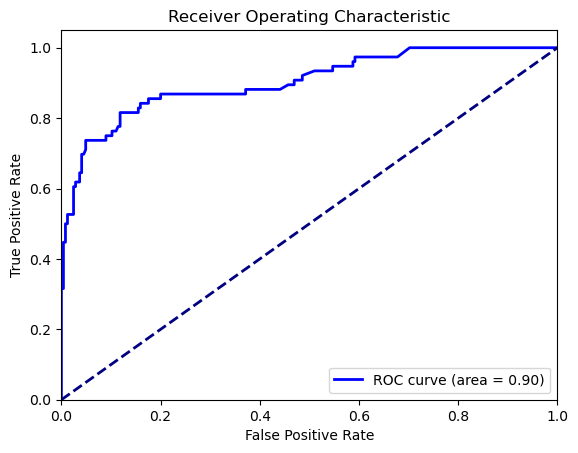

In [15]:
#p_value<0.05

# Select features with p-value < 0.05
significant_vars = ['LOS', 'ASA_RATING_C', 'ORDER_STATUS_IMPACT', 
                    'Erythrocyte distribution width', 'Erythrocyte mean corpuscular hemoglobin', 
                    'Erythrocyte mean corpuscular hemoglobin concentration', 'Erythrocytes', 
                    'cardiac_history']

X = df[significant_vars]
y = df['Cardiovascular'] 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict the target for the test set
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

# Print the classification report
print(classification_report(y_test, y_pred))

# Calculate the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"ROC AUC: {roc_auc}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [36]:
print(significant_vars)

['LOS', 'ASA_RATING_C', 'ORDER_STATUS_IMPACT', 'Erythrocyte distribution width', 'Erythrocyte mean corpuscular hemoglobin', 'Erythrocyte mean corpuscular hemoglobin concentration', 'Erythrocytes', 'cardiac_history']


### Logistic Regression with Cross-Validation: Evaluating Precision, Accuracy, and Recall

In [37]:
X = df[significant_vars]
y = df['Cardiovascular']

log_reg = LogisticRegression(max_iter=10000)

pipeline = make_pipeline(StandardScaler(), log_reg)

scoring = ['precision', 'accuracy', 'recall']

cv_scores = cross_validate(pipeline, X, y, cv=20, scoring=scoring)

precision_mean = np.mean(cv_scores['test_precision'])
accuracy_mean = np.mean(cv_scores['test_accuracy'])
recall_mean = np.mean(cv_scores['test_recall'])

print(f"Average Precision: {precision_mean}")
print(f"Average Accuracy: {accuracy_mean}")
print(f"Average Recall: {recall_mean}")

Average Precision: 0.7623474306051705
Average Accuracy: 0.8539583333333333
Average Recall: 0.6205263157894738
